In [14]:
# This script contains the optimization algorithms for improvement of the ranking
# by adjusting the weights for bm25 score, quality score and popularity score.
# 4 algorithms are tested and compared.

try:
    from sklearn.metrics import ndcg_score
    import numpy as np
    import cma
    from pyswarm import pso
except ModuleNotFoundError:
    %pip install cma 
    %pip install pyswarm 
    from sklearn.metrics import ndcg_score
    import cma
    from pyswarm import pso

import pandas as pd
import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
# from openpyxl.utils import get_column_letter

In [15]:
# Import test data set
# the file is located in the folder Ranking \\gruppende\umwelt.info\int\Zusammenarbeit\Ranking
# It was created as "ranking_test.xlsx" using metadata/notebooks/ranking_create_ranking_table.ipynb and then manually filled with human judged rankings ('ranking_test_alle.xlsx').
df = pd.read_excel("ranking_test_alle.xlsx")

In [16]:
# Define the ranking function with weights a, b
def score_function(weights, df):
    a, b = weights
    score = (
        df["bm25_score"] * (1 + df["quality_score"]) ** a * df["popularity_score"] ** b
    )
    return score


# Define NDCG loss function to minimize
def ndcg_loss(weights, df):
    ndcg_total = 0.0
    queries = df["query"].unique()

    # Compute NDCG per query and average over all queries
    for query in queries:
        query_df = df[df["query"] == query]

        # Filter out irrelevant results (e.g., human_rank = 0)
        relevant_df = query_df[query_df["ranking"] > 0]

        true_ranks = relevant_df["ranking"].values.reshape(1, -1)
        pred_scores = score_function(weights, relevant_df).values.reshape(1, -1)
        ndcg_total += ndcg_score(true_ranks, pred_scores)

    # Return negative for minimizing
    return -ndcg_total

Optimized weights (a, b): (0.12244897959183673, 0.29591836734693877)


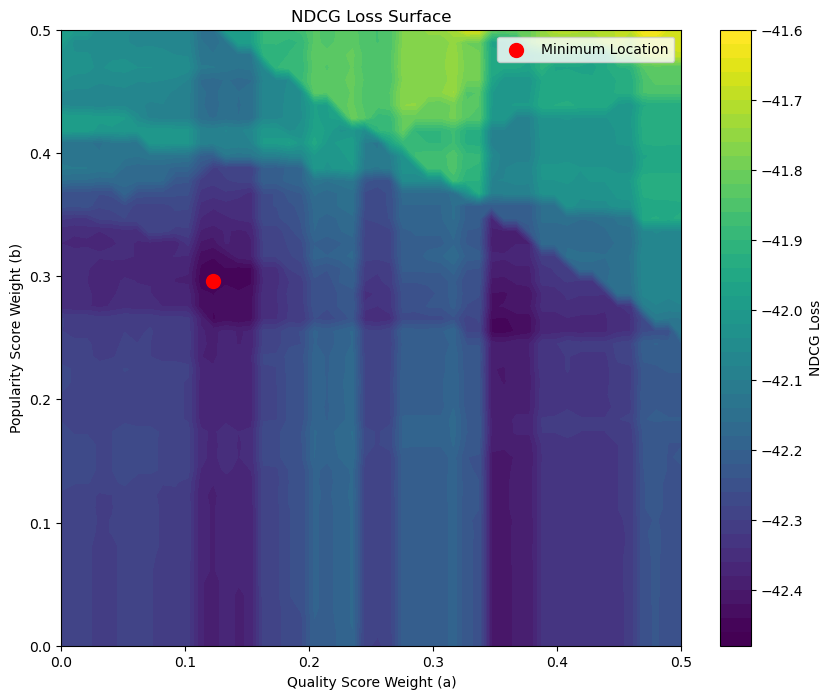

In [17]:
# Basic Method A: Grid search

a_values = np.linspace(0, 0.5, 50)
b_values = np.linspace(0, 0.5, 50)
loss_matrix = np.zeros((len(a_values), len(b_values)))

# Perform the grid search
for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):
        weights = [a, b]
        loss_matrix[i, j] = ndcg_loss(weights, df)

A, B = np.meshgrid(a_values, b_values, indexing="ij")

# Find the minimum of the loss matrix
loss_min = np.min(loss_matrix)
min_loc = np.where(loss_matrix == loss_min)

opt_weights_a = (a_values[min_loc[0][0]], b_values[min_loc[1][0]])
print("Optimized weights (a, b):", opt_weights_a)

plt.figure(figsize=(10, 8))
contour = plt.contourf(
    A,
    B,
    loss_matrix,
    levels=50,
    cmap="viridis",
    vmin=loss_matrix.min(),
    vmax=loss_matrix.max(),
)
plt.scatter(
    a_values[min_loc[0][0]],
    b_values[min_loc[1][0]],
    color="red",
    label="Minimum Location",
    s=100,
)
plt.colorbar(contour, label="NDCG Loss")
plt.title("NDCG Loss Surface")
plt.xlabel("Quality Score Weight (a)")
plt.ylabel("Popularity Score Weight (b)")
plt.legend()
plt.savefig("grid_search.png")
plt.show()

In [18]:
# Method B: CMA-ES (Covariance Matrix Adaptation Evolution Strategy)

# Define the wrapper for the ndcg_loss
def ndcg_loss_cma(weights, df):
    return ndcg_loss(weights, df)


initial_weights = [0, 0]

# Optimize using CMA-ES
es = cma.CMAEvolutionStrategy(initial_weights, 0.5)  # initial weights and sigma
while not es.stop():
    solutions = es.ask()
    losses = [ndcg_loss_cma(sol, df) for sol in solutions]
    es.tell(solutions, losses)

opt_weights_b = es.result.xbest
print("Optimized weights (a, b):", opt_weights_b)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=736912, Fri Oct 11 11:28:47 2024)


Optimized weights (a, b): [0.37867629 0.04765353]


In [19]:
# Method C: Differential Evolution

# Define the wrapper for the ndcg_loss
def de_ndcg_loss(weights, df):
    return ndcg_loss(weights, df)


# Define bounds for the weights (assuming the weights are between 0 and 1)
bounds = [(0, 1), (0, 1)]  # Bounds for weights a, b

# Run Differential Evolution
result = differential_evolution(de_ndcg_loss, bounds, args=(df,))
opt_weights_c = result.x
print("Optimized weights (a, b):", opt_weights_c)

Optimized weights (a, b): [0.3371128  0.26877273]


In [20]:
# Method D: Particle Swarm Optimization (PSO)

# Define the wrapper for the ndcg_loss
def pso_ndcg_loss(weights, df):
    return ndcg_loss(weights, df)


# Define bounds for the weights
lb = [0, 0]  # Lower bound for weights a, b
ub = [1, 1]  # Upper bound for weights a, b

# Run Particle Swarm Optimization
opt_weights_d, opt_val = pso(pso_ndcg_loss, lb, ub, args=(df,), maxiter=30)
print("Optimized weights (a, b):", opt_weights_d)

Stopping search: maximum iterations reached --> 30
Optimized weights (a, b): [0.12148834 0.29548904]


In [24]:
# Conversion from relative to absolute values

d = {
    "Algorithm": ["Grid search", "CMA-ES", "Differential evolution", "PSO"],
    "Param. A (Quality)": [
        opt_weights_a[0],
        opt_weights_b[0],
        opt_weights_c[0],
        opt_weights_d[0],
    ],
    "Param. B (Popularity)": [
        opt_weights_a[1],
        opt_weights_b[1],
        opt_weights_c[1],
        opt_weights_d[1],
    ],
}
df = pd.DataFrame(d)

df["BM25"] = df.apply(
    lambda row: 1 / (1 + row["Param. A (Quality)"] + row["Param. B (Popularity)"]),
    axis=1,
)
df["alpha"] = df.apply(
    lambda row: row["Param. A (Quality)"]
    / (1 + row["Param. A (Quality)"] + row["Param. B (Popularity)"]),
    axis=1,
)
df["beta"] = df.apply(
    lambda row: row["Param. B (Popularity)"]
    / (1 + row["Param. A (Quality)"] + row["Param. B (Popularity)"]),
    axis=1,
)

# Comparison of weighting values for each algorithm
print(df)

                Algorithm  Param. A (Quality)  Param. B (Popularity)  \
0             Grid search            0.122449               0.295918   
1                  CMA-ES            0.378676               0.047654   
2  Differential evolution            0.337113               0.268773   
3                     PSO            0.121488               0.295489   

       BM25     alpha      beta  
0  0.705036  0.086331  0.208633  
1  0.701100  0.265490  0.033410  
2  0.622709  0.209923  0.167367  
3  0.705728  0.085738  0.208535  


In [22]:
d = {
    "Algorithm": ["Grid search", "CMA-ES", "Differential evolution", "PSO"],
    "Param. A (Quality)": [
        opt_weights_a[0],
        opt_weights_b[0],
        opt_weights_c[0],
        opt_weights_d[0],
    ],
    "Param. B (Popularity)": [
        opt_weights_a[1],
        opt_weights_b[1],
        opt_weights_c[1],
        opt_weights_d[1],
    ],
}
d

{'Algorithm': ['Grid search', 'CMA-ES', 'Differential evolution', 'PSO'],
 'Param. A (Quality)': [0.12244897959183673,
  0.378676288364901,
  0.3371127988528566,
  0.12148833830107662],
 'Param. B (Popularity)': [0.29591836734693877,
  0.047653527504914014,
  0.268772725566908,
  0.2954890431163686]}